# Normalization

**Import**

In [2]:
# from second tutorial notebook (Part02)
import scanpy as sc
import pandas as pd
import scvelo as scv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import ipywidgets as widgets

# others
import re
import os

# first tutorial
import bbknn
import diffxpy.api as dxpy
import plotly.express as px

# Meritxell's
import anndata2ri

In [3]:
# Meritxell's normalization
# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
anndata2ri.activate()

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

sc.settings.verbosity = 3
#sc.logging.print_versions()

**Read anndata matrix**

In [65]:
path_out = f'/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/data/mapping/MAC/adata/'

adata_out_mm = f'{path_out}/preproc_1_starsolo_multimap_mac.h5ad'

In [66]:
palette_dict = {"Elongated_spermatids":'#0173B2',"Round_spermatids":'#FF7C00',"Spermatocytes":"green","Spermatogonia":"red"}

In [67]:
# open saved data
adata = sc.read(adata_out_mm)

In [68]:
adata

AnnData object with n_obs × n_vars = 6895 × 24283
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells'
    layers: 'raw_counts', 'spliced', 'unspliced'

In [69]:
cd '/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/tutorial/'

/faststorage/project/testis_singlecell/Workspaces/adahl/birc-project-akd/tutorial


In [4]:
%run Scripts/pythonScripts.py

Exception: File `'Scripts/pythonScripts.py'` not found.

computing PCA
    with n_comps=50
    finished (0:00:08)


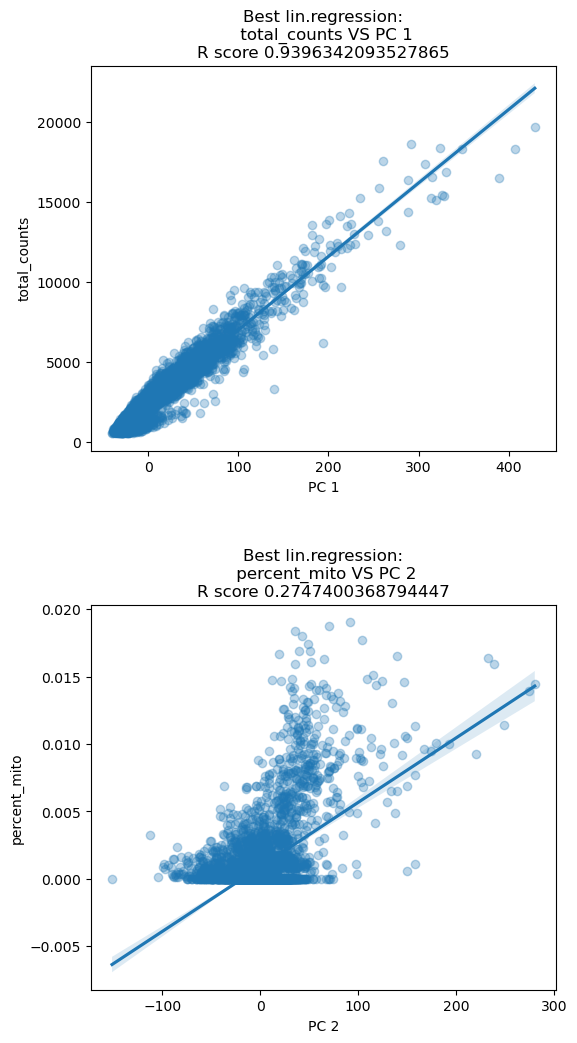

In [71]:
#from /home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/tutorial/Scripts/pythonScripts import dependentFeatures

#PCA on unnormalized data
sc.preprocessing.pca(adata, svd_solver='arpack', random_state=12345)
#Calculating correlations
dependentFeatures(adata=adata, obs_subset=['total_counts','percent_mito']) # plots the PC with the highest R2 to total counts and percent mito, respectively


The third biggest variation in the data at this point is explained by total UMI count

In [72]:
adata

AnnData object with n_obs × n_vars = 6895 × 24283
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_counts', 'spliced', 'unspliced'

In [73]:
rawMatrix = adata.X.todense().T
cells = adata.obs_names
genes = adata.var_names
dataset = np.array(adata.obs["DATASET"])

In [74]:
rawMatrix.shape

(24283, 6895)

In [75]:
%%R -i rawMatrix -i cells -i genes -i dataset -o norm_sct -o umi_corr -o genes_var

library(Seurat)
colnames(rawMatrix) <- cells
rownames(rawMatrix) <- genes
meta <- data.frame(DATASET = dataset)  # add batch as metadata
print(dim(rawMatrix))
seurat_df <- CreateSeuratObject(rawMatrix)
seurat_df <- AddMetaData(seurat_df, meta$DATASET, col.name = "DATASET")
# scTransform
seurat_df <- SCTransform(seurat_df, verbose = TRUE, variable.features.n = length(genes), vars.to.regress = c("DATASET"), return.only.var.genes=FALSE) # normalize data with Negative binomial regression
# Get matrix of residuals
norm_sct <- GetAssayData(seurat_df,assay="SCT",slot="scale.data") # assign normalized and scaled data
umi_corr <- GetAssayData(seurat_df,assay="SCT",slot="counts") # assign counts
genes_var <- rownames(seurat_df$SCT)
# shouldnt I also store the normalized but not scaled counts

[1] 24283  6895


R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 24283 by 6895

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 5000 cells



  |======================================================================| 100%


R[write to console]: Found 29 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 24283 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 24283 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.97474 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Regressing out DATASET

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                         

In [76]:
norm_sct.shape

(24283, 6895)

In [77]:
# remove objects from R workspace that I will no longer need
# %%R
# rm(list = ls())

In [78]:
adata.var_names = ["-".join(x.split("_")) for x in adata.var_names] # change _ in gene names to - so it works in R code
adata = adata[:,np.array(genes_var)].copy() # only use genes ...
# creating SCT layers in anndata object
adata.layers["norm_sct"] = norm_sct.T
adata.layers["umi_corr"] = umi_corr.T

In [81]:
adata.X = adata.layers['norm_sct'].copy() # normalized and scaled matrix as default

In [82]:
sc.pp.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:41)


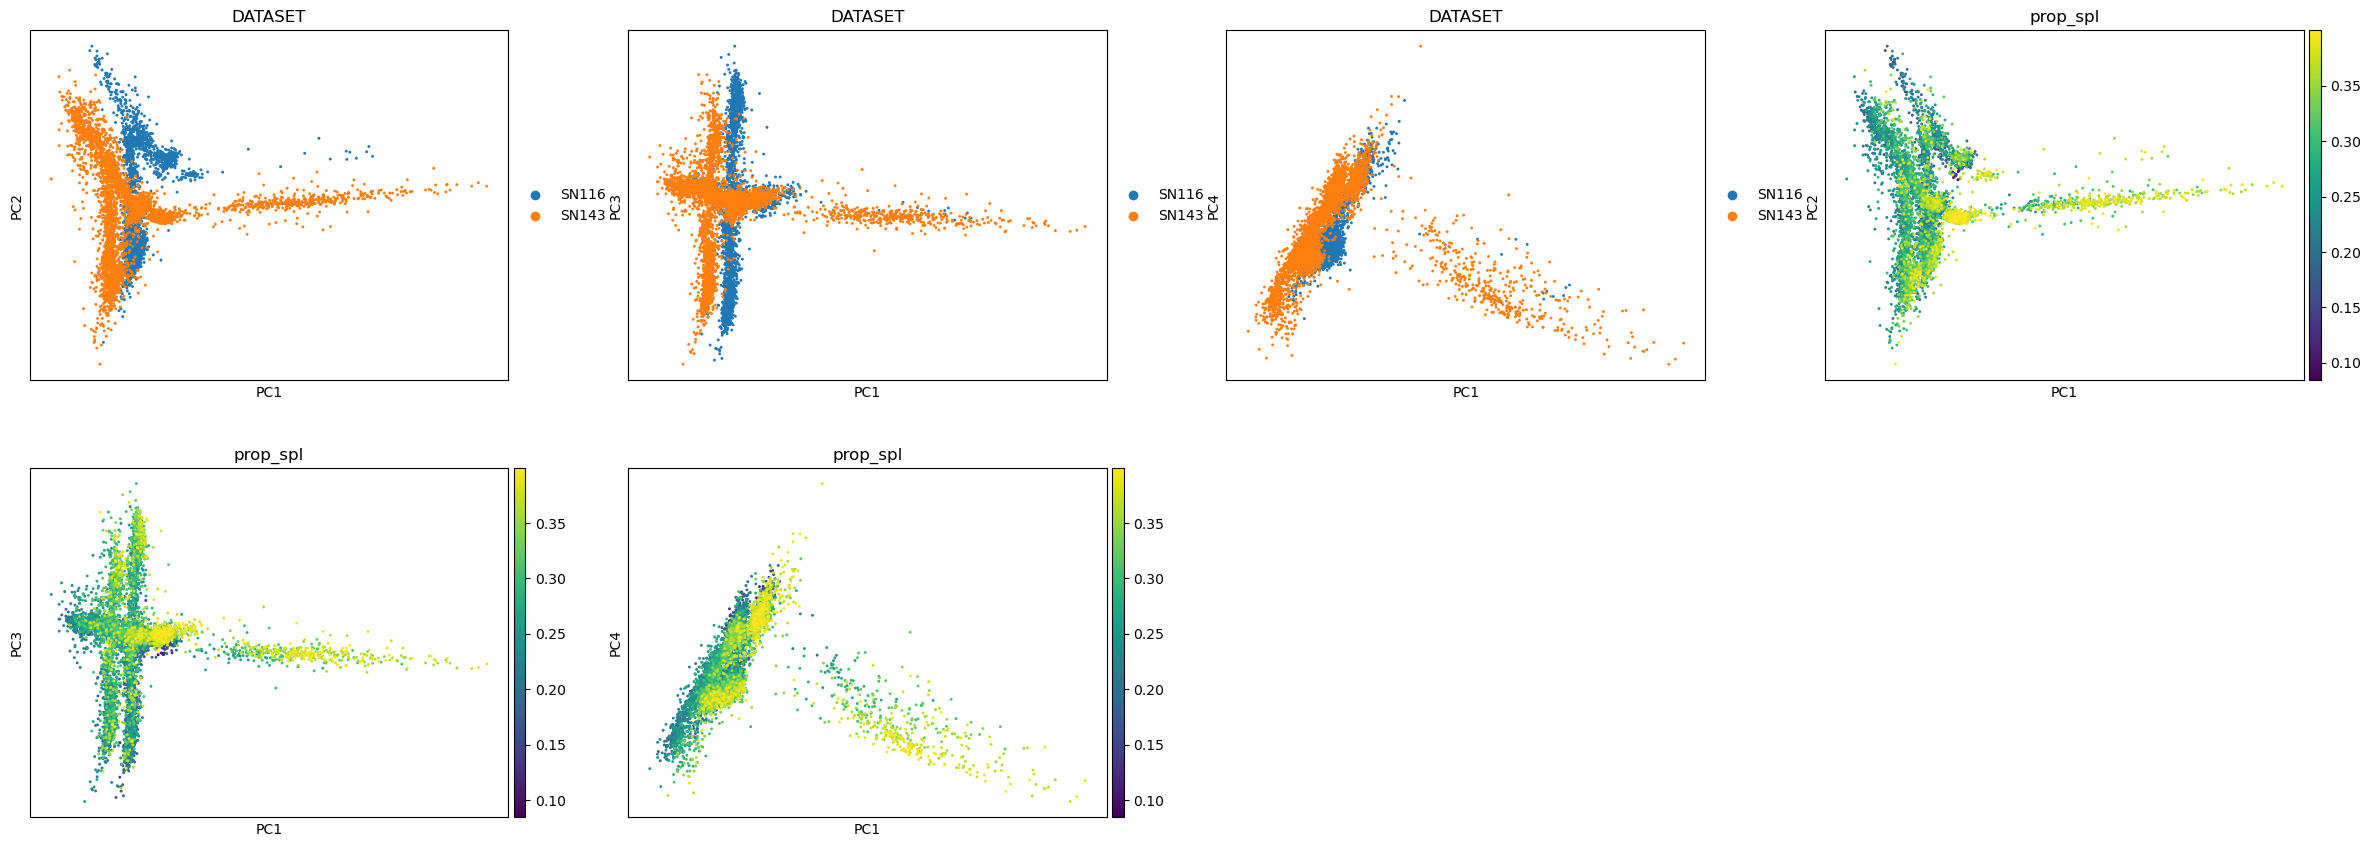

In [83]:
sc.pl.pca(adata, color=['DATASET','prop_spl'], components=['1,2','1,3','1,4'])

In [84]:
# most variable genes, True or False
sc.pp.highly_variable_genes(adata, n_top_genes=10000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [85]:
adata.layers

Layers with keys: raw_counts, spliced, unspliced, norm_sct, umi_corr

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:20)


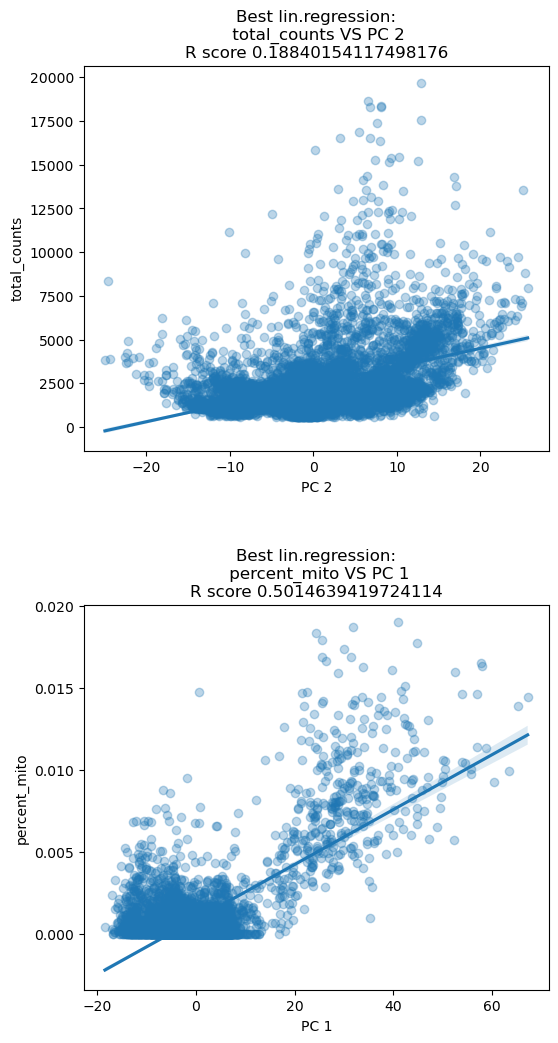

In [86]:
#PCA on normalized data
sc.preprocessing.pca(adata, svd_solver='arpack', random_state=12345)
#Calculating correlations
dependentFeatures(adata=adata, obs_subset=['total_counts','percent_mito'])

Now the correlation isn't strong.

Luckily the samples overlap, so they can be analyzed combined

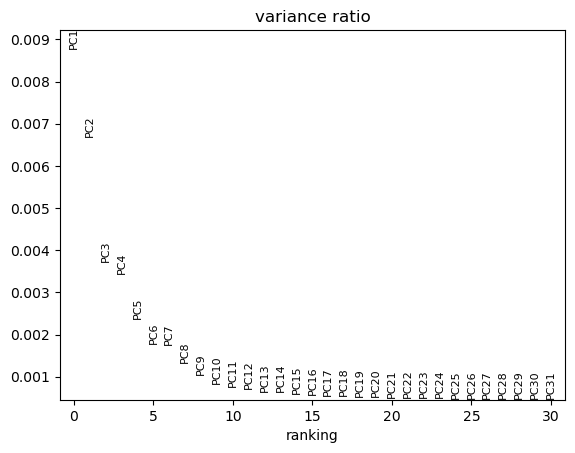

In [87]:
sc.plotting.pca_variance_ratio(adata) # small variance means it probably models noice in the data

Keep the PCs with the most variance, e.g. up to PC10

In [88]:
#sc.pp.neighbors(adata, n_pcs=15, random_state=12345) # use only for data with one single sample
bbknn.bbknn(adata, batch_key='DATASET', n_pcs=10)

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [89]:
sc.tools.umap(adata, random_state=54321)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


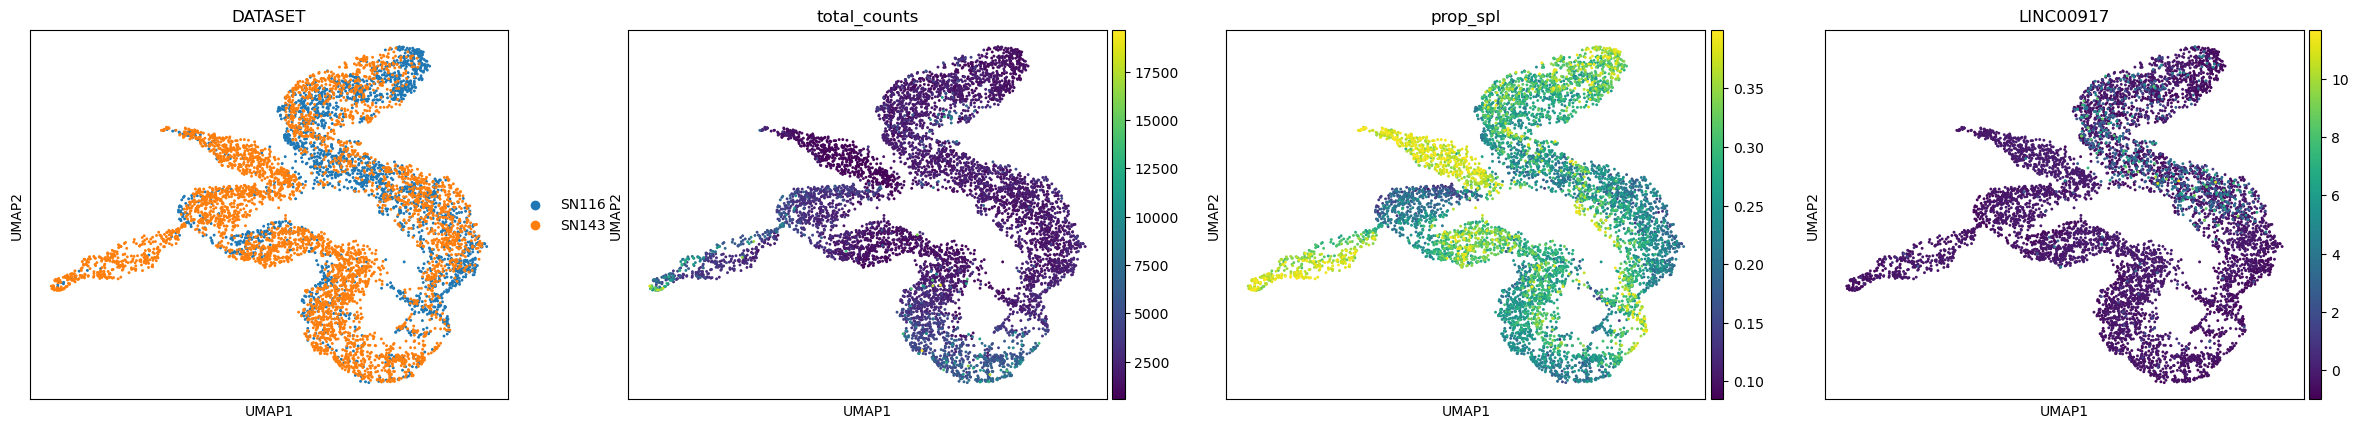

In [90]:
sc.plotting.umap(adata, color=['DATASET','total_counts','prop_spl','LINC00917'])

In [91]:
adata

AnnData object with n_obs × n_vars = 6895 × 24283
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'DATASET_colors', 'hvg', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'spliced', 'unspliced', 'norm_sct', 'umi_corr'
    obsp: 'distances', 'connectivities'

In [92]:
# higher marker scores when only a few is considered and therefore more visible clusters
markers = dict() #make an empty dictionary
### SPERMATOCYTOGENESIS
markers['SpermatogoniaA'] = ['ID4','HMGA1']
markers['SpermatogoniaB'] = ['MKI67','DMRT1','STRA8'] 
markers['SpermatocytesI'] = ['MEIOB','PRSS50','SYCP1','TEX101']
markers['SpermatocytesII'] = ['PIWIL1','ACRV1','SPATA16','CLGN']
### SPERMIOGENESIS
markers['Round.Spt'] = ['SPATA9','SPAM1'] #Round spermatids
markers['Elong.Spt'] = ['PRM1','PRM2'] #Elongated spermatids
### SOMATIC CELLS
markers['Sertoli'] = ['CTSL', 'VIM']
markers['Macroph'] = ['CD163','TYROBP']
markers['Leydig'] = ['CFD']
markers['Endothelial'] = ['CD34']

In [96]:
markers = dict() #make an empty dictionary
# Markers from the group google doc added
### SPERMATOCYTOGENESIS
markers['SpermatogoniaA'] = ['ID4','HMGA1','PIWIL4','UTF1','SLC22A2','FGFR3']
markers['SpermatogoniaB'] = ['MKI67','DMRT1','STRA8','ANP32B','SDF2L1','DMRT1','NANOS3'] # add markers for both?
markers['SpermatocytesI'] = ['MEIOB','PRSS50','SYCP1','TEX101','SPAG6','FTHL17','ART3','KCTD19','ASRGL1','LDHAL6B','LYAR','ZPBP2','ADAM2','CLGN','DDX25'] # general 'MYBL1','SYCP3','HORMAD1','SYNGR4', missing a few pachytene markers
markers['SpermatocytesII'] = ['PIWIL1','ACRV1','SPATA16','CLGN','UBE2T']
### SPERMIOGENESIS
markers['Round.Spt'] = ['SPATA9','SPAM1','DNAJB13','EFHB','LYZL6','PSD3','SLC16A7','TBC1D21','TMEM144'] # missing a few markers
markers['Elong.Spt'] = ['PRM1','PRM2','AGPAT2','AKAP1','BAG1','CST8','DNAJB7','DNAJB8','FNDC8','LELP1','RANGAP1','SPATA3','TSSK6','TXNDC2','TNP1','TP53TG5']
### SOMATIC CELLS
markers['Sertoli'] = ['CTSL','VIM','ACSL4','WT1','GAS6','BCAR1','DMRT1']
markers['Macroph'] = ['CD163','TYROBP']
markers['Leydig'] = ['ACTA2','CFD','IGF1','IGFBP5','CYP19A1','CYP17A1','INSL3']
markers['Endothelial'] = ['CD34']

In [100]:
# markers in article and course mixed
markers = dict() #make an empty dictionary
#markers['SpermatogoniaB'] = ['MKI67','DMRT1','STRA8'] 
### SPERMATOCYTOGENESIS
markers['Undif. SG'] = ['ID4','HMGA1']
markers['Dif. SG'] = ['MKI67','DMRT1','STRA8'] 
markers['SC.I'] = ['MEIOB','PRSS50','SYCP1','TEX101']
markers['SC.II'] = ['PIWIL1','ACRV1','SPATA16','CLGN']
### SPERMIOGENESIS
markers['Early round SD'] = ['LRRIQ1'] #Round spermatids, Distinct #better than tutorial
markers['Late round SD'] = ['ACRV1','SPACA1'] #Round spermatids, Distinct #better than tutorial
markers['Elong SD'] = ['SPATA3','NRBP1','PRM1','GABBR2'] #Elongated spermatids #better than tutorial
### SOMATIC CELLS
markers['Sertoli'] = ['CLU'] # very distinct #better than tutorial
markers['Macroph'] = ['APOE','CD74']
markers['Leydig'] = ['STAR','CYP11A1']
markers['Endothelial'] = ['CD34'] #'TM4SF1' not expressed

In [101]:
markers_scores, adata = marker_score(markers, adata)

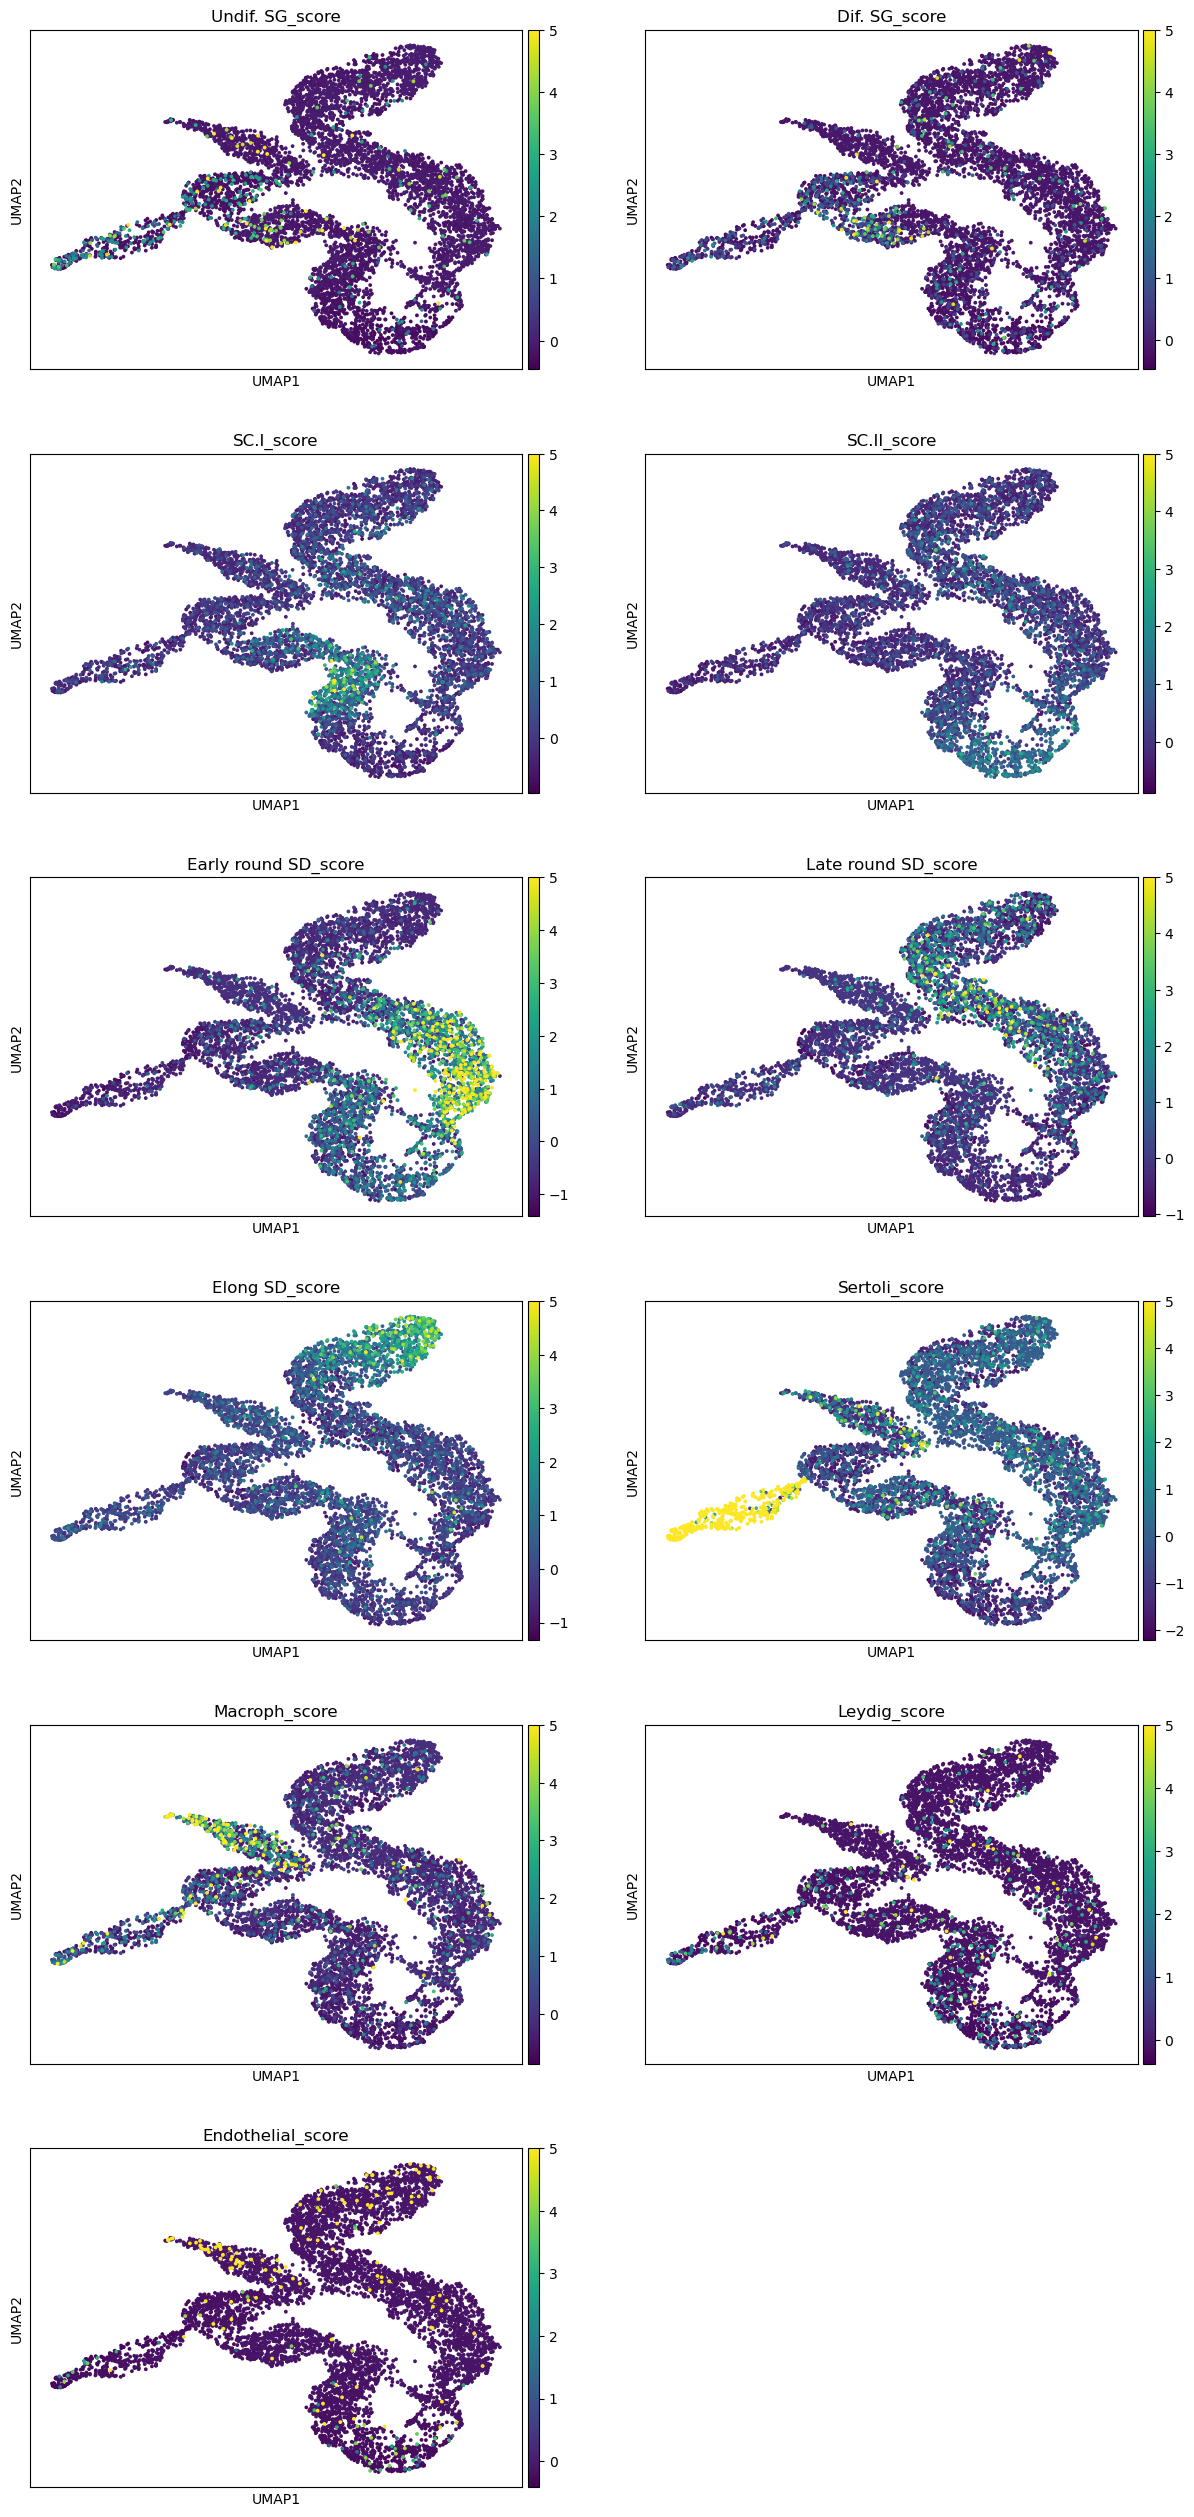

In [102]:
sc.plotting.umap(adata, color=markers_scores, components=['1,2'], ncols=2, vmax=5, s=30)

In [103]:
#leiden clustering at various resolutions
sc.tools.leiden(adata, resolution=0.3, random_state=12345, key_added='leiden_R.3')
sc.tools.leiden(adata, resolution=0.2, random_state=12345, key_added='leiden_R.2')
sc.tools.leiden(adata, resolution=0.1, random_state=12345, key_added='leiden_R.1')

running Leiden clustering
    finished: found 11 clusters and added
    'leiden_R.3', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_R.2', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_R.1', the cluster labels (adata.obs, categorical) (0:00:00)


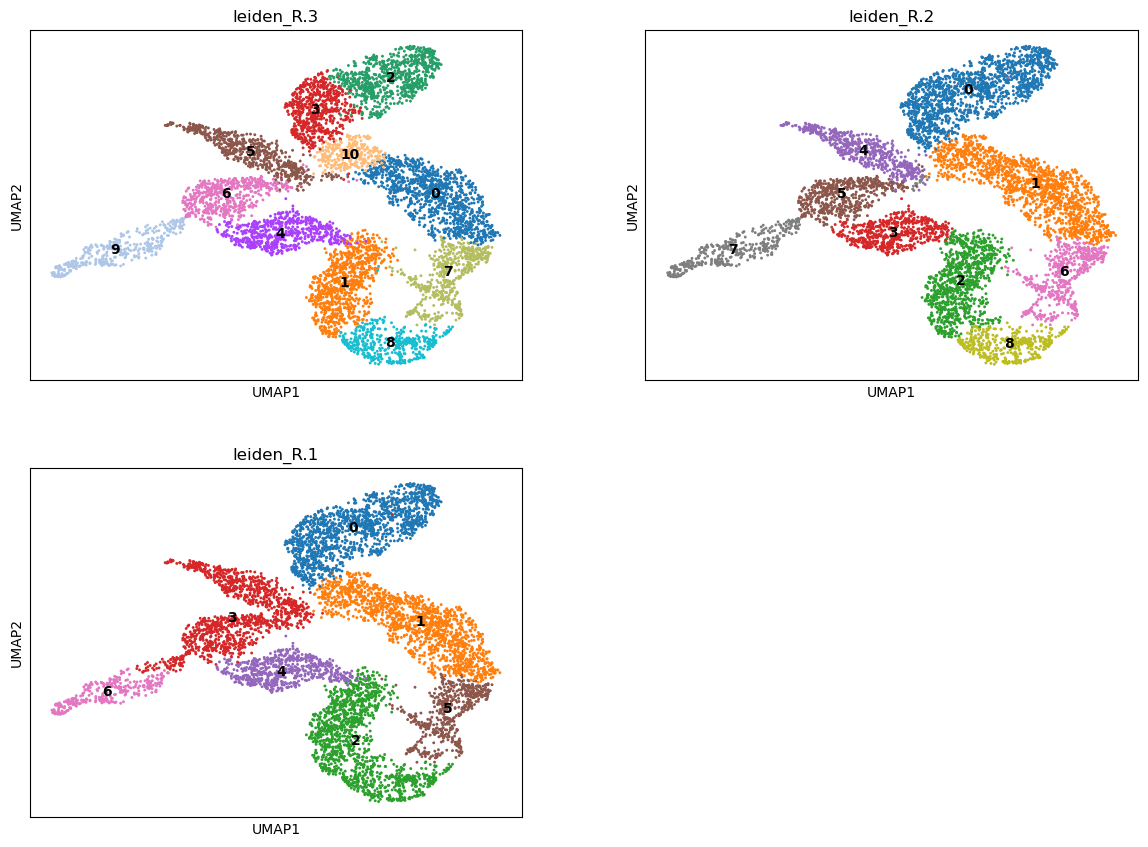

In [104]:
sc.plotting.umap(adata, color=['leiden_R.3','leiden_R.2','leiden_R.1'], legend_loc='on data', ncols=2)

In [106]:
adata

AnnData object with n_obs × n_vars = 6895 × 24283
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets', 'SpermatogoniaA_score', 'SpermatogoniaB_score', 'SpermatocytesI_score', 'SpermatocytesII_score', 'Round.Spt_score', 'Elong.Spt_score', 'Sertoli_score', 'Macroph_score', 'Leydig_score', 'Endothelial_score', 'Undif. SG_score', 'Dif. SG_score', 'SC.I_score', 'SC.II_score', 'Early round SD_score', 'Late round SD_score', 'Elong SD_score', 'leiden_R.3', 'leiden_R.2', 'leiden_R.1'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'DATASET_colors', 'hvg', 'neighbors', 'umap', 'leiden', 'leiden_R.3_colors', 'leiden_R.2_colors', 'leiden_R.1_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'spliced', 'unspliced', 'norm_sct', 'umi_corr'
    obsp: 'distances', 

Comparing the Leiden clusters to the clusters represented by cell markers resolution 0,3 match the best

In [107]:
sc.tl.rank_genes_groups(adata, groupby='leiden_R.3', n_genes=50, key_added='DE_leiden') # diff.expressed genes in each cluster (t-test)

ranking genes
    finished: added to `.uns['DE_leiden']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


In [108]:
adata.uns['DE_leiden']

{'params': {'groupby': 'leiden_R.3',
  'reference': 'rest',
  'method': 't-test',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('GPC6', 'RRP8', 'PRM1', 'CCSER1', 'KCNQ1', 'MALAT1', 'ACTR3B', 'LRRIQ1', 'ANKRD30A', 'LOC101929200', 'COL25A1'),
            ('CNBD1', 'PFDN6', 'NFIC', 'TMEM191B', 'KCNQ1OT1', 'DCN', 'RBFOX1', 'WDR64', 'ZNF385D', 'CLU', 'EDIL3'),
            ('RGL4', 'TTC28', 'PRM2', 'PCDH15', 'amplicon-chrY-TSPY1/10/2/3/4/8', 'TSHZ2', 'FOXP1', 'MIA2', 'ANKRD30B', 'COX3', 'SMIM23'),
            ...,
            ('NFIC', 'ADGRL3', 'GLIPR1L1', 'PNISR', 'LINC00993', 'ANKRD30B', 'ANKRD30B', 'SMIM23', 'ACSM6', 'LOC101927284', 'LOC105373673'),
            ('RALGPS2-AS1', 'BBX', 'SPAG16', 'ADAM2', 'GLIPR1L1', 'LOC101927284', 'GLIPR1L1', 'HDAC11', 'RGL4', 'PTPN22', 'LOC101927284'),
            ('MALAT1', 'RGL4', 'LRRIQ1', 'LOC101927284', 'ANKRD30A', 'ANKRD30A', 'ANKRD30A', 'TMEM191B', 'BBX', 'ANKRD30A', 'ANKRD20A1')],
           dty

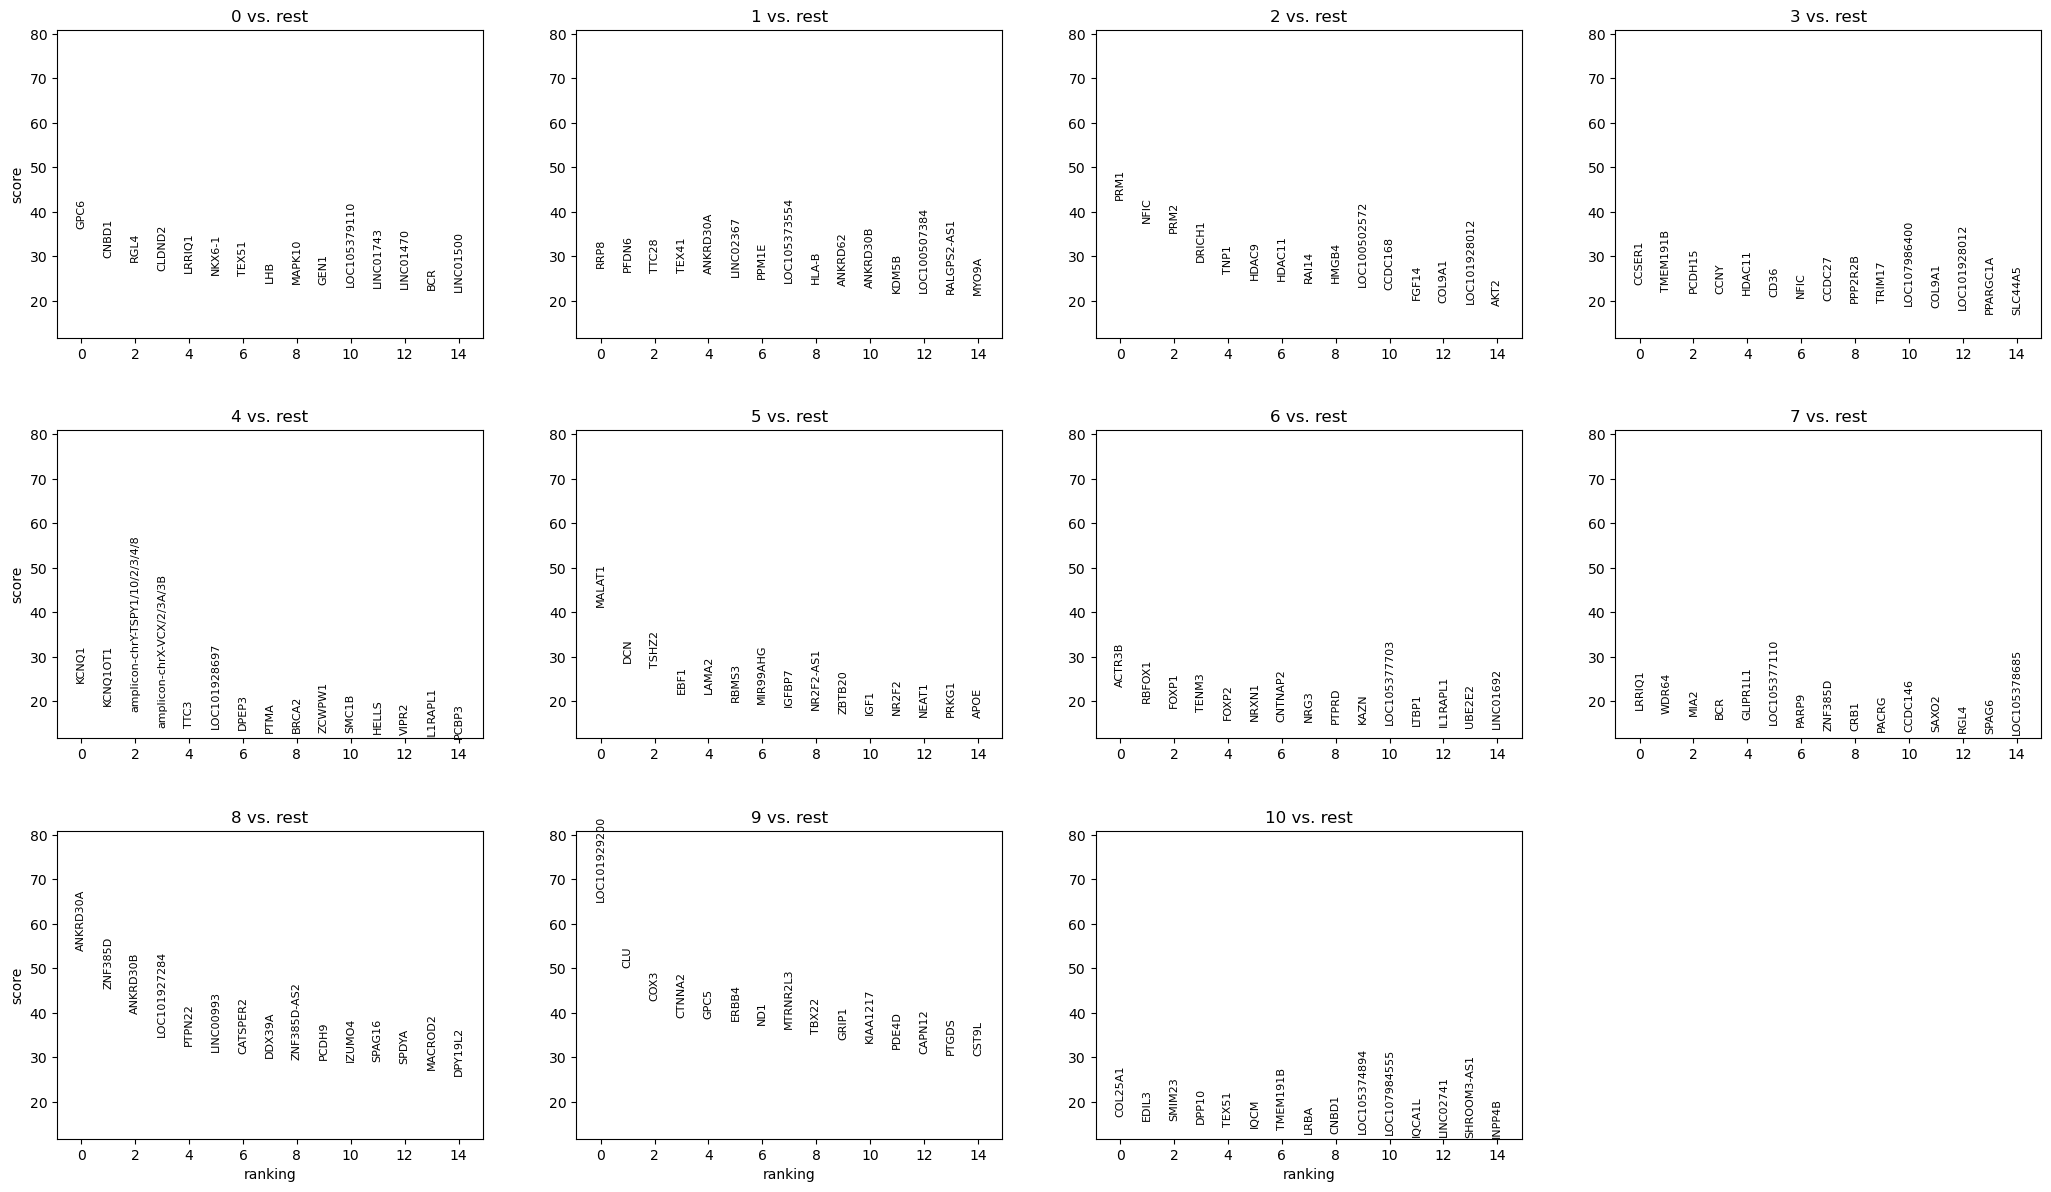

In [110]:
sc.pl.rank_genes_groups(adata, n_genes=10, groupby='leiden_R.3', key='DE_leiden') # sharey=False to change y axis to individual score

In [111]:
adata

AnnData object with n_obs × n_vars = 6895 × 24283
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets', 'SpermatogoniaA_score', 'SpermatogoniaB_score', 'SpermatocytesI_score', 'SpermatocytesII_score', 'Round.Spt_score', 'Elong.Spt_score', 'Sertoli_score', 'Macroph_score', 'Leydig_score', 'Endothelial_score', 'Undif. SG_score', 'Dif. SG_score', 'SC.I_score', 'SC.II_score', 'Early round SD_score', 'Late round SD_score', 'Elong SD_score', 'leiden_R.3', 'leiden_R.2', 'leiden_R.1'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'DATASET_colors', 'hvg', 'neighbors', 'umap', 'leiden', 'leiden_R.3_colors', 'leiden_R.2_colors', 'leiden_R.1_colors', 'DE_leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'spliced', 'unspliced', 'norm_sct', 'umi_corr'
    obsp: 

Organize result in a table. Each column has the cluster numbers with _N, _P, _L representing respectively the gene Names, their P-values and the Log-fold change of each gene expression compared to the other clusters.

In [112]:
result = adata.uns['DE_leiden']
groups = result['names'].dtype.names
X = pd.DataFrame(
    {group + '_' + key[:1].upper(): result[key][group]
    for group in groups for key in ['names', 'pvals_adj']})
X.head() #print only first five lines

0_N            0_P       1_N            1_P     2_N            2_P  \
0    GPC6  3.634450e-190      RRP8  1.272300e-119    PRM1  6.654350e-206   
1   CNBD1  1.751634e-142     PFDN6  1.170914e-112    NFIC  1.484757e-177   
2    RGL4  1.114772e-135     TTC28  4.974180e-114    PRM2  2.435856e-164   
3  CLDND2  3.332281e-120     TEX41  3.424132e-111  DRICH1  3.179231e-124   
4  LRRIQ1  1.082165e-117  ANKRD30A  1.196941e-113    TNP1  2.653223e-106   

        3_N           3_P                             4_N           4_P  ...  \
0    CCSER1  5.001927e-88                           KCNQ1  3.058110e-89  ...   
1  TMEM191B  1.328315e-78                        KCNQ1OT1  3.656967e-61  ...   
2    PCDH15  1.157516e-78  amplicon-chrY-TSPY1/10/2/3/4/8  6.593410e-55  ...   
3      CCNY  1.397705e-76       amplicon-chrX-VCX/2/3A/3B  2.280110e-37  ...   
4    HDAC11  1.860477e-75                            TTC3  2.251376e-37  ...   

      6_N           6_P       7_N           7_P           8_N            8_P  \
0  ACTR3B  1.030236e-86    LRRIQ1  2.482961e-56      ANKRD30A  1.809176e-198   
1  RBFOX1  2.022862e-64     WDR64  2.058200e-51       ZNF385D  2.726118e-165   
2   FOXP1  4.205104e-58      MIA2  9.086341e-50      ANKRD30B  4.637581e-148   
3   TENM3  8.534365e-55       BCR  5.316720e-46  LOC101927284  1.208983e-127   
4   FOXP2  1.561474e-45  GLIPR1L1  6.505095e-45        PTPN22  2.108075e-118   

            9_N            9_P     10_N          10_P  
0  LOC101929200  2.016991e-214  COL25A1  4.447898e-42  
1           CLU  2.120134e-172    EDIL3  3.283848e-39  
2          COX3  5.701253e-149   SMIM23  5.850724e-39  
3        CTNNA2  1.615039e-136    DPP10  3.471935e-36  
4          GPC5  1.413886e-135    TEX51  5.273968e-34  

[5 rows x 22 columns]

In [113]:
pd.DataFrame(adata.uns['DE_leiden']['names']).head() # top 5 ranked genes for each cluster

0         1       2         3                               4       5  \
0    GPC6      RRP8    PRM1    CCSER1                           KCNQ1  MALAT1   
1   CNBD1     PFDN6    NFIC  TMEM191B                        KCNQ1OT1     DCN   
2    RGL4     TTC28    PRM2    PCDH15  amplicon-chrY-TSPY1/10/2/3/4/8   TSHZ2   
3  CLDND2     TEX41  DRICH1      CCNY       amplicon-chrX-VCX/2/3A/3B    EBF1   
4  LRRIQ1  ANKRD30A    TNP1    HDAC11                            TTC3   LAMA2   

        6         7             8             9       10  
0  ACTR3B    LRRIQ1      ANKRD30A  LOC101929200  COL25A1  
1  RBFOX1     WDR64       ZNF385D           CLU    EDIL3  
2   FOXP1      MIA2      ANKRD30B          COX3   SMIM23  
3   TENM3       BCR  LOC101927284        CTNNA2    DPP10  
4   FOXP2  GLIPR1L1        PTPN22          GPC5    TEX51

In [114]:
cd /home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/results

/faststorage/project/testis_singlecell/Workspaces/adahl/birc-project-akd/results


In [115]:
!mkdir -p cluster_results/MAC

In [116]:
X.to_csv('cluster_results/MAC/expr_annotation.csv', sep=',', index=None)

In [118]:
# cell type names for the chosen clusters

#new_names = {
#    '0':'SpermatogoniaA.1',
#    '1':'SpermatogoniaA.2',
#    '2':'Myoid',
#    '3':'Endothelial',
#    '4':'Leydig',
#    '5':'SpermatogoniaB',
#    '6':'Elong_Spermatids',
#    '7':'SpermatocitesII.1',
#    '8':'SpermatocitesII.2',
#    '9':'Round_Spermatids',
#    '10':'SpermatocitesI',
#    '11':'Macroph',
#    '12':'Pericytes'}


new_names = {
    '0':'Early round SD',
    '1':'SC.I',
    '2':'Elong SD',
    '3':'Late round SD',
    '4':'Dif. SG',
    '5':'Undif. SG',
    '6':'Undif. SG',
    '7':'Early round SD',
    '8':'SC.II',
    '9':'Sertoli',
    '10':'Late round SD'
}


We merge the clusters with same names. This cannot be done with a categorical object, where categories cannot have the same name. We convert the cluster names into a simple array to do this, and then reconvert it to a categorical object.

In [121]:
adata.obs['spermatogenesis_types'] = [new_names[x] for x in adata.obs['leiden_R.3'].tolist()]

In [6]:
palette_dict = {"Undif. SG":'lightblue',"Dif. SG":'blue',"SC.I":'lightgreen','SC.II':'green','Early round SD':'yellow','Late round SD':'orange','Elong SD':'red','Sertoli':'pink'}

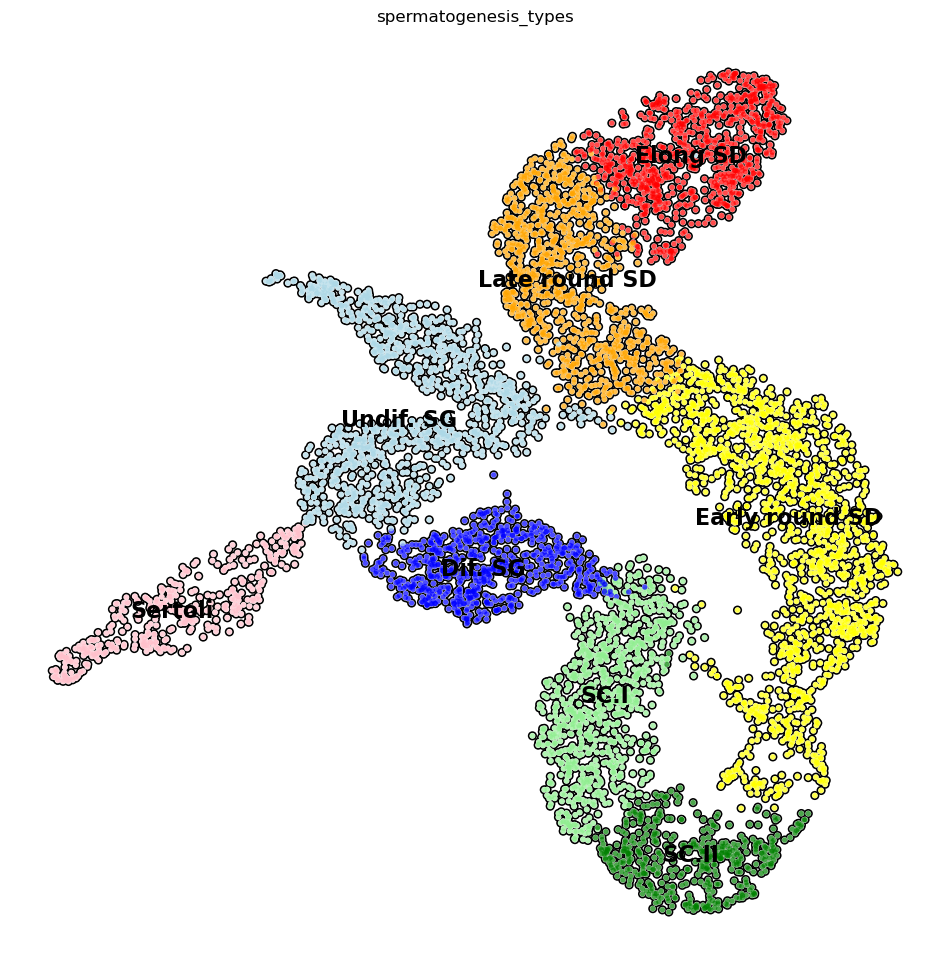

In [7]:
plt.rcParams['figure.figsize'] = (12,12)
sc.pl.umap( adata, color=['spermatogenesis_types'],
           palette=palette_dict,
           legend_loc='on data', 
           legend_fontsize=16,
           frameon=False,
           size=60,
           add_outline=True,
           ncols=1  
           )

In [11]:
saved_adata = '/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/results/cluster_results/MAC/cluster_adata.h5ad'
adata = sc.read(saved_adata)

In [12]:
adata

AnnData object with n_obs × n_vars = 6895 × 24283
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets', 'SpermatogoniaA_score', 'SpermatogoniaB_score', 'SpermatocytesI_score', 'SpermatocytesII_score', 'Round.Spt_score', 'Elong.Spt_score', 'Sertoli_score', 'Macroph_score', 'Leydig_score', 'Endothelial_score', 'Undif. SG_score', 'Dif. SG_score', 'SC.I_score', 'SC.II_score', 'Early round SD_score', 'Late round SD_score', 'Elong SD_score', 'leiden_R.3', 'leiden_R.2', 'leiden_R.1', 'spermatogenesis_types'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DATASET_colors', 'DE_leiden', 'hvg', 'leiden', 'leiden_R.1_colors', 'leiden_R.2_colors', 'leiden_R.3_colors', 'neighbors', 'pca', 'spermatogenesis_types_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'norm_sct', 'r

In [13]:
sc.tl.rank_genes_groups(adata, groupby='spermatogenesis_types', n_genes=50, key_added='DE_leiden_celltype') # diff.expressed genes in each cluster (t-test)

ranking genes
    finished: added to `.uns['DE_leiden_celltype']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


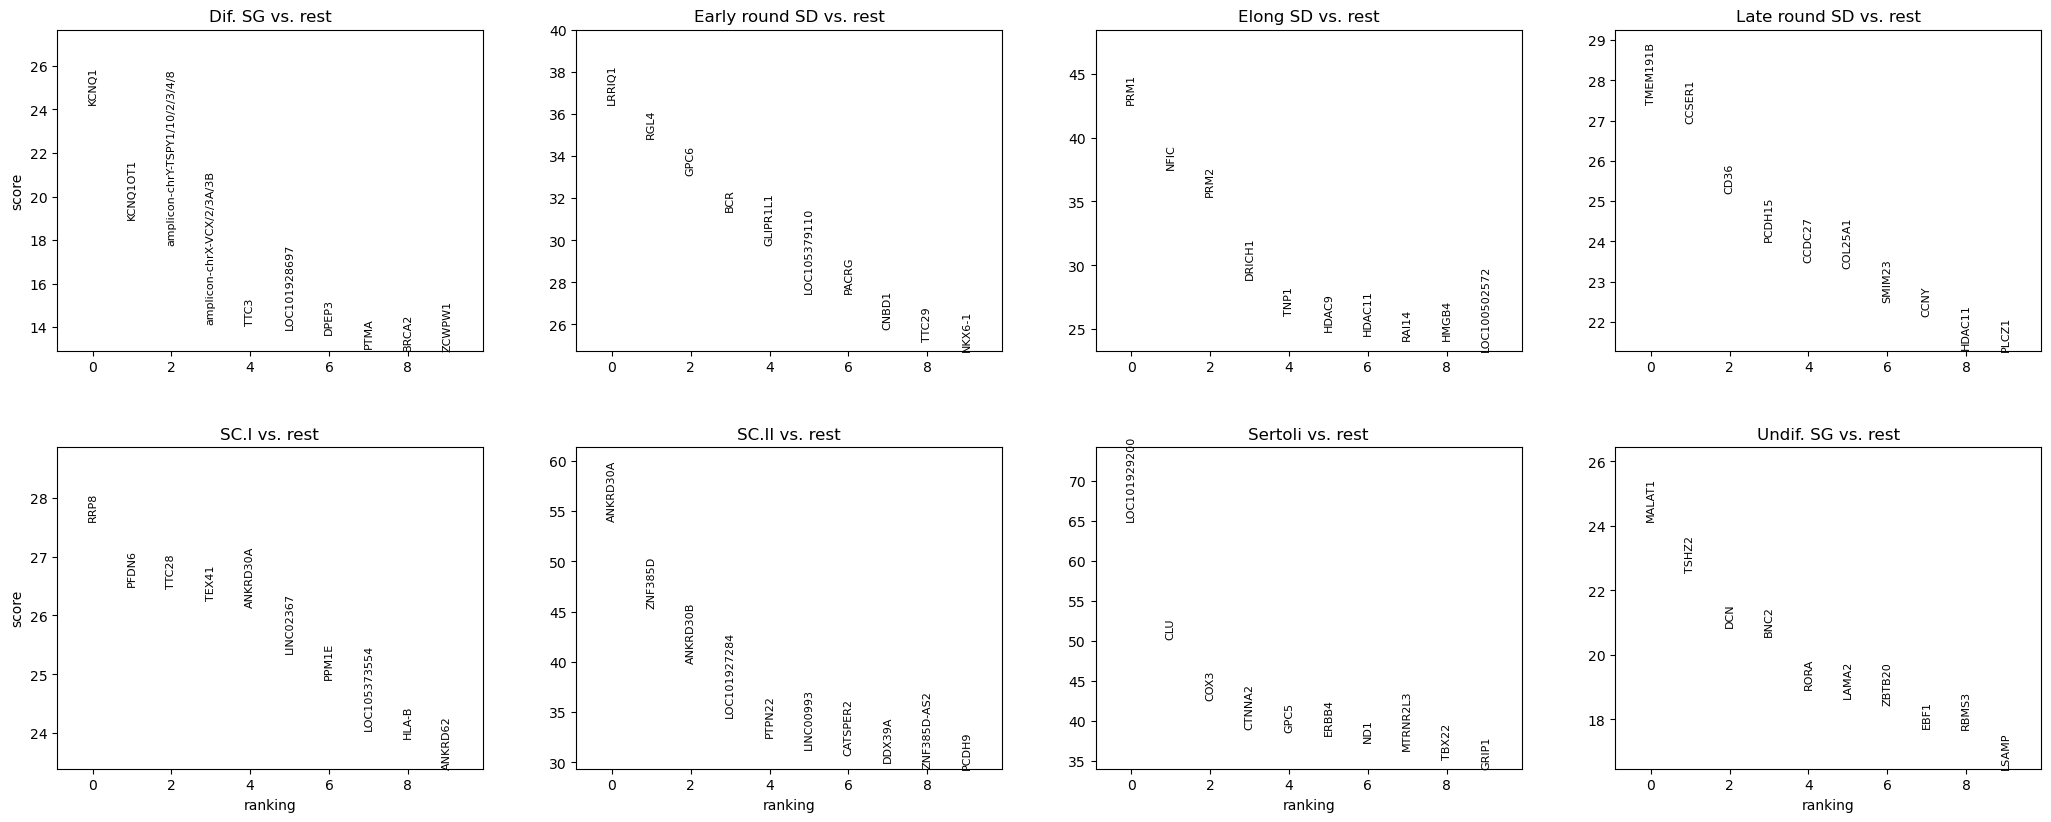

In [14]:
sc.pl.rank_genes_groups(adata, n_genes=10, groupby='spermatogenesis_types', key='DE_leiden_celltype', sharey=False) # sharey=False to change y axis to individual score

In [15]:
result2 = adata.uns['DE_leiden_celltype']
groups2 = result2['names'].dtype.names
X2 = pd.DataFrame(
    {group + '_' + key[:1].upper(): result2[key][group]
    for group in groups2 for key in ['names', 'pvals_adj']})
X2.head() #print only first five lines

Dif. SG_N     Dif. SG_P Early round SD_N  \
0                           KCNQ1  3.058110e-89           LRRIQ1   
1                        KCNQ1OT1  3.656967e-61             RGL4   
2  amplicon-chrY-TSPY1/10/2/3/4/8  6.593410e-55             GPC6   
3       amplicon-chrX-VCX/2/3A/3B  2.280110e-37              BCR   
4                            TTC3  2.251376e-37         GLIPR1L1   

   Early round SD_P Elong SD_N     Elong SD_P Late round SD_N  \
0     7.842562e-214       PRM1  6.654350e-206        TMEM191B   
1     5.208425e-200       NFIC  1.484757e-177          CCSER1   
2     1.449757e-184       PRM2  2.435856e-164            CD36   
3     1.114657e-169     DRICH1  3.179231e-124          PCDH15   
4     3.086541e-157       TNP1  2.653223e-106          CCDC27   

   Late round SD_P    SC.I_N         SC.I_P       SC.II_N        SC.II_P  \
0    1.365605e-121      RRP8  1.272300e-119      ANKRD30A  1.809176e-198   
1    9.443454e-120     PFDN6  1.170914e-112       ZNF385D  2.726118e-165   
2    6.745125e-105     TTC28  4.974180e-114      ANKRD30B  4.637581e-148   
3     1.619196e-99     TEX41  3.424132e-111  LOC101927284  1.208983e-127   
4     2.924147e-94  ANKRD30A  1.196941e-113        PTPN22  2.108075e-118   

      Sertoli_N      Sertoli_P Undif. SG_N    Undif. SG_P  
0  LOC101929200  2.016991e-214      MALAT1  3.919891e-102  
1           CLU  2.120134e-172       TSHZ2   3.114312e-91  
2          COX3  5.701253e-149         DCN   9.410495e-80  
3        CTNNA2  1.615039e-136        BNC2   1.759695e-78  
4          GPC5  1.413886e-135        RORA   3.085978e-68

In [16]:
cd /home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/results

/faststorage/project/testis_singlecell/Workspaces/adahl/birc-project-akd/results


In [20]:
X2.to_csv('cluster_results/MAC/expr_annotation_celltype.csv', sep=',', index=None)

In [18]:
path_out = f'/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/results/cluster_results/MAC'

if not os.path.exists(path_out):
    os.makedirs(path_out)

adata_out = f'{path_out}/cluster_adata.h5ad'

In [19]:
adata.write(adata_out)